# AIChE 2017 -- *Hands On With Molecular Simulation*


## Part 1 - Running simulations with HOOMD-blue and analyzing results with Freud

This example shows how to initialize a system of particles and execute dissipative particle dynamics simulations with **HOOMD**. Then it demonstrates how to analyze the simulation output with **Freud**.

### Initialization

We start by initializing the execution context for HOOMD, which determines how the simulation is actually executed.
When no command line options are provided, HOOMD will auto-select a GPU if one is available, or alternatively run on the CPU.

***You have not mentioned a command line interface at all yet. I would skip this entirely, at least for this stage. Here you can just state that the context initialization takes arguments to select GPU or CPU usage.***

In [1]:
import hoomd
import hoomd.md

hoomd.context.initialize('');

HOOMD-blue v2.2.0 CUDA (8.0) DOUBLE HPMC_MIXED MPI SSE SSE2 
Compiled: 10/06/2017
Copyright 2009-2017 The Regents of the University of Michigan.
-----
You are using HOOMD-blue. Please cite the following:
* J A Anderson, C D Lorenz, and A Travesset. "General purpose molecular dynamics
  simulations fully implemented on graphics processing units", Journal of
  Computational Physics 227 (2008) 5342--5359
* J Glaser, T D Nguyen, J A Anderson, P Liu, F Spiga, J A Millan, D C Morse, and
  S C Glotzer. "Strong scaling of general-purpose molecular dynamics simulations
  on GPUs", Computer Physics Communications 192 (2015) 97--107
-----
notice(2): This system is not compute exclusive, using local rank to select GPUs
notice(2): Unable to identify node local rank information
notice(2): Using global rank to select GPUs
HOOMD-blue is running on the following GPU(s):
 [0]          Quadro K6000  15 SM_3.5 @ 0.901 GHz, 12204 MiB DRAM, DIS


Next, we specify the initial conditions of the particles in the simulation. Define a square lattice of A and B particles:

In [4]:
a = 0.6
unitcell = hoomd.lattice.unitcell(N=4,
                                  a1=(2*a, 0,   0),
                                  a2=(0,   2*a, 0),
                                  a3=(0,   0,   1),
                                  dimensions=2,
                                  position=[(0,0,0), (0,a,0), (a,0,0), (a,a,0)],
                                  type_name=['A', 'B', 'B', 'A'])

Replicate the unit cell to place many particles.

***You should add a quick sentence about how snapshots store system state. Otherwise the transition from unitcell-> snapshot is abrupt and unmotivated***

In [5]:
snapshot = unitcell.get_snapshot()
snapshot.replicate(15, 15, 1)

By default, particles have 0 velocity. Set a Gaussian random velocity using numpy.

In [6]:
import numpy as np

snapshot.particles.velocity[:,0:2] = np.random.normal(0.0, np.sqrt(0.8 / 1.0), [snapshot.particles.N, 2])

The lattice initialization placed an equal number of A and B particles. Randomly set 1/4 of the particles in the box to type B and the rest to type A.

In [7]:
index_array = np.arange(snapshot.particles.N)
np.random.shuffle(index_array)
snapshot.particles.typeid[:] = snapshot.particles.types.index('A')
snapshot.particles.typeid[index_array[:int(snapshot.particles.N/4)]] = snapshot.particles.types.index('B')

Initialize the system with this snapshot as the system configuration.

***Again, if possible should have some brief explanation distinguishing between snapshots and the system. Could mention that snapshots can be created from multiple things, including system and unitcell objects, although that might be too detailed***

In [8]:
hoomd.init.read_snapshot(snapshot);

notice(2): Group "all" created containing 900 particles


Let's look at the system initial configuration ***using matplotlib***.

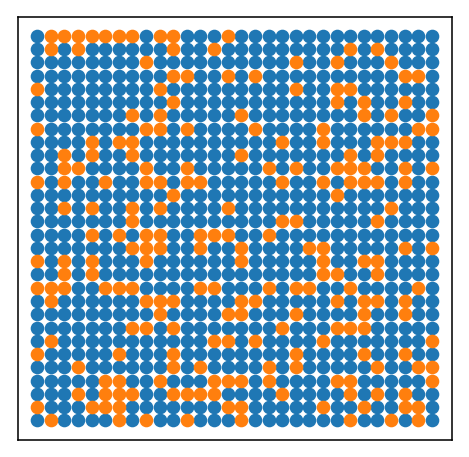

In [19]:
from matplotlib import pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(4, 4), dpi=140)
pos_a = snapshot.particles.position[snapshot.particles.typeid==snapshot.particles.types.index('A'), :]
pos_b = snapshot.particles.position[snapshot.particles.typeid==snapshot.particles.types.index('B'), :]
ax.plot(pos_a[:,0], pos_a[:,1], 'o')
ax.plot(pos_b[:,0], pos_b[:,1], 'o')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

### Force field definition

In the DPD polymer model, pairs of particles closer than $r_\mathrm{cut}$ interact with a linear conservative force, a drag force that depends on the relative velocity, and a random force. The parameter A specifies the strength of the repulsive force.

Choose the neighbor list acceleration structure to find neighboring particles efficiently. In systems with only one cutoff length, the cell method performs best.

***Are we targeting users who know how neighbor lists work? This is useful but seems pretty high-level***

In [9]:
nl = hoomd.md.nlist.cell()

Define the functional form of the pair interaction and evaluate using the given neighbor list acceleration structure. $kT$ defines the temperature of the system in energy units and *seed* defines the seed for the random number generator.

In [10]:
dpd = hoomd.md.pair.dpd(r_cut=1.0, nlist=nl, kT=0.8, seed=1)

-----
You are using DPD. Please cite the following:
* C L Phillips, J A Anderson, and S C Glotzer. "Pseudo-random number generation
  for Brownian Dynamics and Dissipative Particle Dynamics simulations on GPU
  devices", Journal of Computational Physics 230 (2011) 7191--7201
-----


Specify pair potential parameters for every pair of types in the simulation. Each line sets the strength of the repulsive force for A-A, A-B, and B-B particle interactions respectively.

In [11]:
dpd.pair_coeff.set('A', 'A', A=10.0, gamma = 1.0)
dpd.pair_coeff.set('A', 'B', A=10.0, gamma = 1.0)
dpd.pair_coeff.set('B', 'B', A=10.0, gamma = 1.0)

### Setting up the integrator

The integrator defines the equations of motion that govern the system of particles, given the current configuration of the particles and the net force from all potentials. The standard integration mode in HOOMD allows different integrators to apply to different groups of particles with the same step size $dt$.

In [12]:
hoomd.md.integrate.mode_standard(dt=0.01);

``pair.dpd`` applies the random and drag forces consistent with a thermal system and should be used with the *NVE* integrator.

***Why use the NVE integrator? Do you expect users to understand that from this tutorial?***

In [13]:
all = hoomd.group.all();
hoomd.md.integrate.nve(group=all);

### Write Output

Periodically log the potential energy of the system to a text file.

In [14]:
hoomd.analyze.log(filename='log-output.log',
                  quantities=['potential_energy', 'temperature'],
                  period=100,
                  overwrite=True);

In [15]:
hoomd.dump.gsd('trajectory.gsd', period=500, group=all, overwrite=True);

### Run the simulation

Take 5000 steps forward in time.

In [16]:
hoomd.run(5000)

notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 900
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
** starting run **
Time 00:03:01 | Step 5000 / 5000 | TPS 689.218 | ETA 00:00:00
Average TPS: 689.134
---------
-- Neighborlist stats:
775 normal updates / 17 forced updates / 0 dangerous updates
n_neigh_min: 10 / n_neigh_max: 22 / n_neigh_avg: 16.1422
shortest rebuild period: 5
-- Cell list stats:
Dimension: 12, 12, 1
n_min    : 3 / n_max: 10 / n_avg: 6.25
** run complete **


### Examining the output

Use matplotlib to plot the potential energy and temperature vs time step.

Good equilibration *may* be indicated by an extended period where the potential energy has leveled off.

In [17]:
data = np.genfromtxt(fname='log-output.log', names=True)

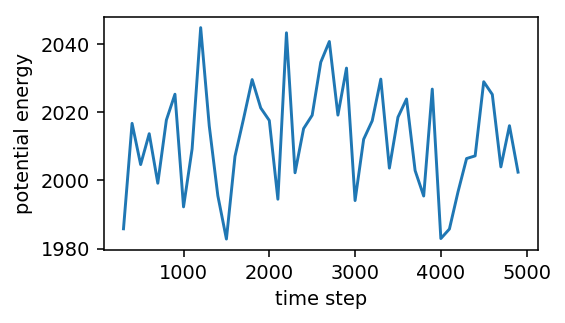

In [20]:
fig, ax = plt.subplots(figsize=(4, 2.2), dpi=140)
ax.plot(data['timestep'][3:], data['potential_energy'][3:])
ax.set_xlabel('time step')
ax.set_ylabel('potential energy')

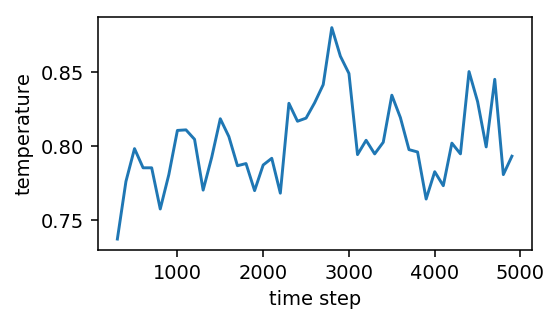

In [21]:
fig, ax = plt.subplots(figsize=(4, 2.2), dpi=140)
ax.plot(data['timestep'][3:], data['temperature'][3:])
ax.set_xlabel('time step')
ax.set_ylabel('temperature')

Structural analysis provides a much stronger signal for proper equilibration. 

First, examine the system configuration in the final frame of the trajectory. Use [gsd] to read the file and matplotlib to plot it.

[gsd]: https://gsd.readthedocs.io

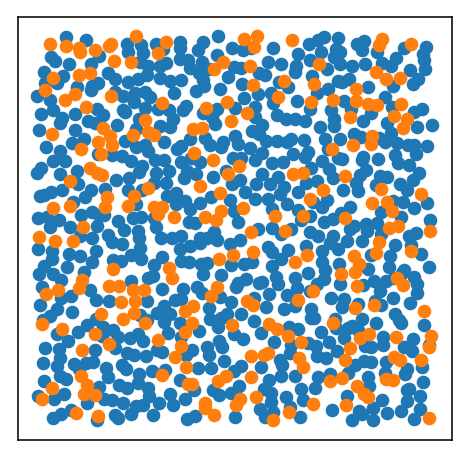

In [22]:
import gsd
import gsd.hoomd

fig, ax = plt.subplots(figsize=(4, 4), dpi=140)
with gsd.hoomd.open('trajectory.gsd') as traj:
    frame = traj[-1];
    pos_a = frame.particles.position[frame.particles.typeid==frame.particles.types.index('A'), :]
    pos_b = frame.particles.position[frame.particles.typeid==frame.particles.types.index('B'), :]
    ax.plot(pos_a[:,0], pos_a[:,1], 'o')
    ax.plot(pos_b[:,0], pos_b[:,1], 'o')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

Use [freud] to cluster the B particles in every frame of the trajectory. Then, plot the number of clusters vs time.

[freud]: https://glotzerlab.engin.umich.edu/freud

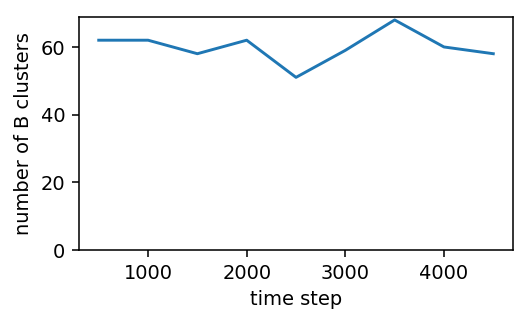

In [23]:
import freud
step = []
n_clusters = []

with gsd.hoomd.open('trajectory.gsd') as traj:
    for frame in traj[1:]:
        box = freud.box.Box(Lx=frame.configuration.box[0], Ly=frame.configuration.box[1], is2D=True)
        cluster = freud.cluster.Cluster(box, 1.0)
        pos_b = frame.particles.position[frame.particles.typeid==frame.particles.types.index('B'), :]
        cluster.computeClusters(pos_b)
        
        step.append(frame.configuration.step)
        n_clusters.append(cluster.getNumClusters())
    
fig, ax = plt.subplots(figsize=(4, 2.2), dpi=140)
ax.plot(step, n_clusters, '-')
ax.set_ylim(ymin=0)
ax.set_xlabel('time step')
ax.set_ylabel('number of B clusters')

In [24]:
print(n_clusters)

[62, 62, 58, 62, 51, 59, 68, 60, 58]


## Exercises

### 1. Phase separation

Modify one simulation parameter so that the A and B particles phase separate. After changing the value, select Cell->Run All to rerun the notebook and observe the result.

### 2. Equilibration

Now that you have the system phase separating, examine the simulation output carefully. Is the system fully equilibrated? Change the script and run it again and see if you can get the system to equilibrate completely.